In [1]:
import numpy as np
import networkx as nx
import DNGR_utils as ut
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, noise
from keras.models import Model

Using TensorFlow backend.


In [2]:
#Stage 1 -  Random Surfing
def random_surf(cosine_sim_matrix, num_hops, alpha):
    
    num_nodes = len(cosine_sim_matrix)
    
    adj_matrix = ut.scale_sim_matrix(cosine_sim_matrix)
    P0 = np.eye(num_nodes, dtype='float32')
    P = np.eye(num_nodes, dtype='float32')
    A = np.zeros((num_nodes,num_nodes),dtype='float32')
    
    for i in range(num_hops):
        P = (alpha*np.dot(P,adj_matrix)) + ((1-alpha)*P0)
        A = A + P

    return A

In [3]:
#Stage 2 - PPMI Matrix
def PPMI_matrix(A):
    
    num_nodes = len(A)
    A = ut.scale_sim_matrix(A)
    
    row_sum = np.sum(A, axis=1).reshape(num_nodes,1)
    col_sum = np.sum(A, axis=0).reshape(1,num_nodes)
    
    D = np.sum(col_sum)
    PPMI = np.log(np.divide(np.multiply(D,A),np.dot(row_sum,col_sum)))
    #Gotta use numpy for division, else it runs into divide by zero error, now it'll store inf or -inf
    #All Diag elements will have either inf or -inf.
    #Get PPMI by making negative values to 0
    PPMI[np.isinf(PPMI)] = 0.0
    PPMI[np.isneginf(PPMI)] = 0.0
    PPMI[PPMI<0.0] = 0.0
    
    return PPMI

In [4]:
def sdae(PPMI, hidden_neurons):
    
    inp = Input(shape=(PPMI.shape[1],))
    enc = noise.GaussianNoise(0.2)(inp)
    
    for neurons in hidden_neurons:
        enc = Dense(neurons, activation = 'relu')(enc)
    
    dec = Dense(hidden_neurons[-2], activation = 'relu')(enc)
    for neurons in hidden_neurons[:-3][::-1]:
        dec = Dense(neurons, activation = 'relu')(dec)
    dec = Dense(PPMI.shape[1], activation='relu')(dec)
    
    auto_enc = Model(inputs=inp, outputs=dec)
    auto_enc.compile(optimizer='adam', loss='mse')
    
    auto_enc.fit(x=PPMI, y=PPMI, batch_size=10, epochs=5)
    
    encoder = Model(inputs=inp, outputs=enc)
    encoder.compile(optimizer='adam', loss='mse')
    embeddings = encoder.predict(PPMI)
    
    return embeddings

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0114
Epoch 2/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0102
Epoch 3/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0096
Epoch 4/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0090
Epoch 5/5
600/600 [==============================] - 1s 1ms/step - loss: 0.0085

Evaluated embeddings using Multinomial Naive Bayes
F1 - score(Macro) :  0.9217265278197179
NMI :  0.703943936876178


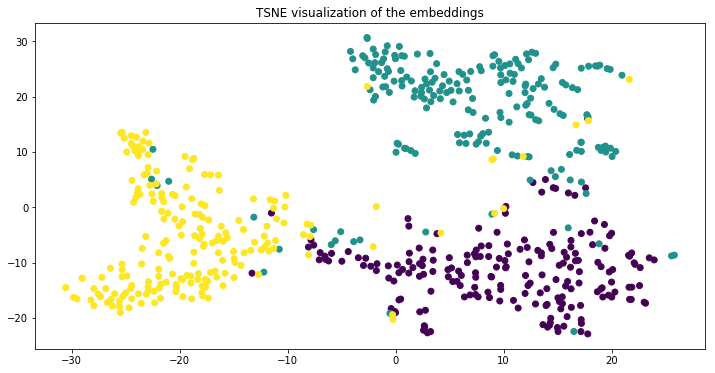

In [5]:
text_corpus, file_names, target = ut.read_data()
cosine_sim_matrix = ut.get_cosine_sim_matrix(text_corpus)

A = random_surf(cosine_sim_matrix, 3, 0.98)
PPMI = PPMI_matrix(A)

embeddings = sdae(PPMI, [512,256,128])

#Save embeddings

#Metrics
ut.compute_metrics(embeddings, target)

#visualize embeddings using tsne
ut.visualize_TSNE(embeddings, target)
plt.show()
